# Kaggle Contest - House Prices

In [ ]:
#Importing likely packages needed for data exploration and imputing NaNs.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import scipy as stats
from scipy.stats import norm, skew
from scipy import mean
from math import sqrt

In [2]:
#Import Data
#Combine the test / train sets into a single df called combine.
train = pd.read_csv('train.csv')
train_ID = train['Id']
train = train.drop(['Id'], axis = 1)
test = pd.read_csv('test.csv')
test_ID = test['Id']
test = test.drop(['Id'], axis = 1)
train['Label'] = 0
test['Label'] = 1
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


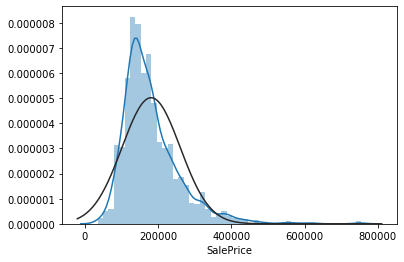

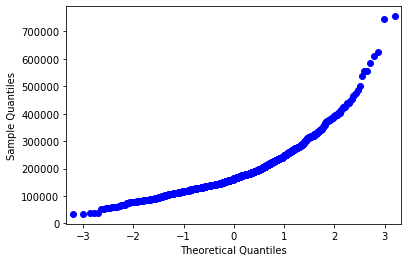

In [3]:
#See if SalePrice target variable needs to be transformed.
#Run distplot against a normal distribution
#distplot
sns.distplot(train['SalePrice'], fit=norm)
#Get also the QQ-plot
sm.qqplot(train['SalePrice'])
plt.show()

In [4]:
#SalePrice is not normally distributed. Regression models will assume normality of errors. Best to 
#tranform using log function.
#transform SalePrice using np.log1p
train['SalePrice'] = np.log1p(train['SalePrice'])

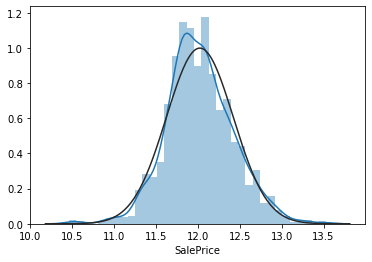

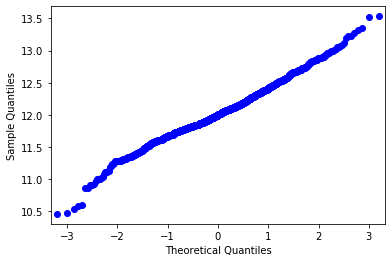

In [5]:
#distplot
sns.distplot(train['SalePrice'], fit=norm)
#Get also the QQ-plot
sm.qqplot(train['SalePrice'])
plt.show()

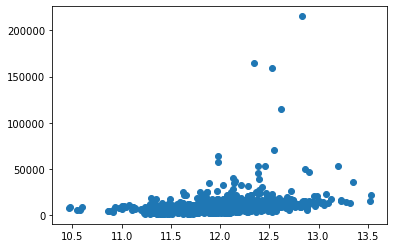

In [6]:
#do outlier analysis here.
plt.scatter(train.SalePrice, train.LotArea)
#four sales over 100,000 sqft. Looks like those might be farmland. Can remove to avoid their effect on the target.

In [7]:
#remove all lots bigger than 100,000 sq ft.
print(train.shape)
train = train[train['LotArea'] < 100000]
print(train.shape)

(1460, 81)
(1456, 81)


In [8]:
#combine the training and test data sets now that outliers have been removed.
y = train['SalePrice']
combine = pd.concat((train, test)).reset_index(drop=True)
combine.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(combine.shape))

all_data size is : (2915, 80)


In [9]:
#Check the skew of the numerical categories. Any highly skewed variables will need to be transformed using 
#box cox tranformation.
from scipy import stats
from scipy.stats import norm, skew #for some statistics
numericals = combine.dtypes[combine.dtypes != 'object'].index
skew_num = combine[numericals].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame({'Skew' :skew_num})
skewness.head(10)

,Skew
MiscVal,21.955311
PoolArea,16.886625
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.160088
EnclosedPorch,4.000796
ScreenPorch,3.943508
BsmtHalfBath,3.941288
LotArea,3.749733


In [12]:
#make a df of highly skewed variables
skewness = skewness[abs(skewness) > .75]
print('There are a total of {} variables to transform due to skewness'.format(len(skewness)))

There are a total of 37 variables to transform due to skewness


In [13]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for features in skewed_features:
    combine[features] = boxcox1p(combine[features], lam)

In [14]:
#check dimensions of all dfs.
print(train.shape)
print(test.shape)
print(combine.shape)

(1456, 81)
(1459, 80)
(2915, 80)


In [15]:
#Put all column names into a single variable
colnames = pd.DataFrame(train.columns, columns = ['ColumnNames'])

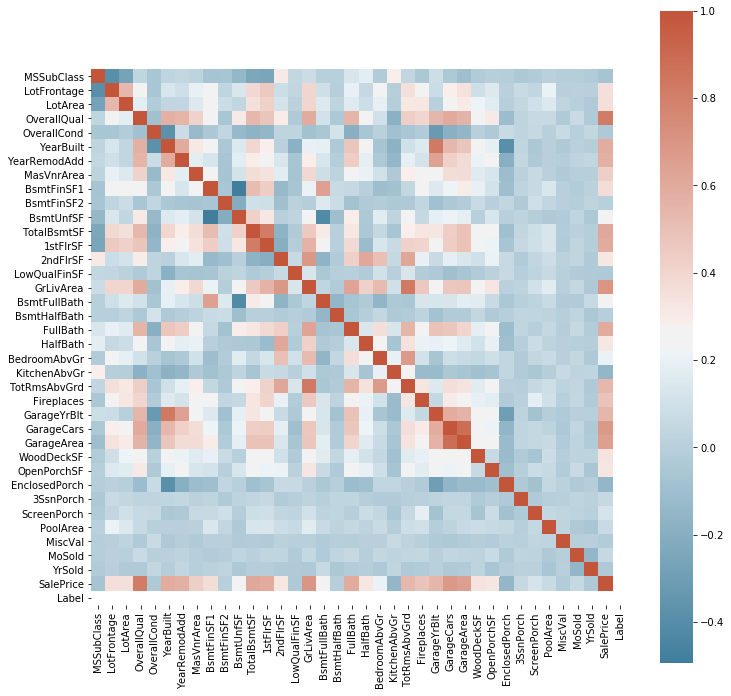

In [16]:
#Check correlation of variables with the target variable.
train_corr = train.corr(method = 'pearson')
f, ax = plt.subplots(figsize = (12,12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train_corr, cmap = cmap, square = True)

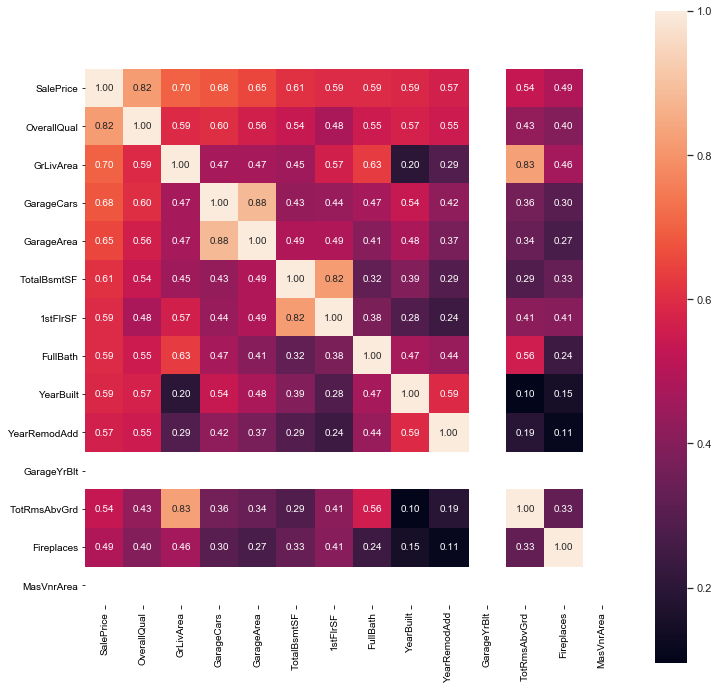

In [17]:
#Let's check corrplot with SalePrice to see what correlates best with SalePrice
f, ax = plt.subplots(figsize = (12,12))
k = 14 #number of variables for heatmap
cols = train_corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.00)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
#Looks like OverallQual, GrLivArea, GarageCars, Garage Area are best.
#For the area variables (GrLivArea, TotalBsmtSF, 1stFlrSF), should just create a variable for TotalSF.
cols = cols.drop(['SalePrice'])
combine2 = combine[cols]

In [18]:
## Missing Values
#Let's check through all of the variables to see how many are missing.
missing_vals = pd.DataFrame(combine.isnull().sum()/len(combine))
missing_vals.columns = ['Percent_Missing']
missing_vals = missing_vals.sort_values(by = ['Percent_Missing'], ascending = False)
missing_vals.head(34)

,Percent_Missing
PoolQC,0.996569
MiscFeature,0.964666
Alley,0.932075
Fence,0.804117
FireplaceQu,0.487136
LotFrontage,0.165695
GarageCond,0.054545
GarageQual,0.054545
GarageYrBlt,0.054545
GarageFinish,0.054545


In [19]:
#34 predictors with at least some missing values. There are some useful groupings to remove these NaNs.
#PoolQC , Fence, FirePlaceQual, GarageYrBuilt, GarageCond, GarageQual, BsmtExposure, BsmtQual, 
#BsmtFinType1, BsmtFinType2, MasVnrType, MiscFeature, Alley 'NA' = 'None'. (From the Kaggle Documentation) 
#Let's just replace it with none.

for col in ('PoolQC', 'Fence', 'FireplaceQu', 'GarageYrBlt', 'GarageCond', 'GarageQual', 'BsmtExposure',
           'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MiscFeature', 'Alley', 'GarageFinish',
           'GarageType', 'BsmtCond'):
    combine[col] = combine[col].fillna('None')

In [20]:
#LotFrontage has 16% zero. There is probably a pretty good correlation between the LotFrontage and which neighborhood the
#house is in. Let's replace NaN's with the median of the LotFrontage for the neighborhood.

combine['LotFrontage'] = combine.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [21]:
#All the basement continuous variables above where there is NA means no basement. (From the Kaggle Documentation) 
#Can replace with zero.
for col in ('TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'BsmtFullBath', 
            'BsmtHalfBath', 'GarageCars', 'GarageArea', 'MasVnrArea'):
    combine[col] = combine[col].fillna(0)

In [22]:
#fill MSZoning with mode
combine['MSZoning'] = combine['MSZoning'].fillna(combine['MSZoning'].mode()[0])
#fill Exterior1st and Exterior2nd with mode
combine['Exterior1st'] = combine['Exterior1st'].fillna(combine['Exterior1st'].mode()[0])
combine['Exterior2nd'] = combine['Exterior2nd'].fillna(combine['Exterior2nd'].mode()[0])

In [23]:
#fill Functional with 'Typ'
combine['Functional'] = combine['Functional'].fillna('Typ')

In [24]:
#fill the rest with mode
for col in ('Utilities', 'Electrical', 'SaleType', 'KitchenQual'):
    combine[col] = combine[col].fillna(combine[col].mode()[0])

In [25]:
#Let's check again the NaNs to see if we're imputing the expected columns.
#Let's recheck the missing values to see that those have been removed.
missing_vals = pd.DataFrame(combine.isnull().sum()/len(combine))
missing_vals.columns = ['Percent_Missing']
missing_vals = missing_vals.sort_values(by = ['Percent_Missing'], ascending = False)
missing_vals.head(2)
#all NaNs gone.

,Percent_Missing
MSSubClass,0.0
MSZoning,0.0


In [27]:
#Feature Engineering
# Predictors to remove / create
# From the GrLivArea + 1stFlrSF + 2ndFlrSF make a variable for TotalSF
combine['TotalSF'] = combine['GrLivArea'] + combine['1stFlrSF'] + combine['2ndFlrSF']

In [29]:
# Variable Transformation
# Some variables are dtype float64 or int64, but are really categorical.
print(combine['MSSubClass'].dtype)
print(combine['OverallCond'].dtype)
print(combine['MoSold'].dtype)
print(combine['YrSold'].dtype)

float64
float64
float64
float64


In [30]:
#covert these variables into categories
items = ('MSSubClass', 'OverallCond', 'MoSold', 'YrSold')
for cols in items:
    combine[cols] = combine[cols].astype(str)

In [31]:
#Variables will be easier to deal with if they're properly encoded. Several variables are 'levels'. i.e. they should be
#label encoded (i.e. the categories should be 1,2,3 to represent the structures of the levels.)
items = combine.select_dtypes(include='object').columns
for cols in items:
    lbl = LabelEncoder()
    lbl.fit(list(combine[cols].values))
    combine[cols] = lbl.transform(list(combine[cols].values))
print('Shape of combine {}'.format(combine.shape))

Shape of combine (2915, 81)


In [32]:
#let's make a cluster variable using KNN.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 10) 
#Cluster on all values
combine['Cluster'] = kmeans.fit_predict(combine)
combine['Cluster'] = combine['Cluster'].astype('int')

In [33]:
#Separate train and test dataframes
train2 = combine[combine['Label'] == 0]
test2 = combine[combine['Label'] != 0]
train2 = train2.drop(['Label'], axis = 1)
test2 = test2.drop(['Label'], axis = 1)
X = train2
y = train['SalePrice']

In [34]:
# Build Models
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# evaluate an lasso regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso

In [35]:
#do gridsearch here.
lasso_params = {'alpha':list(np.linspace(0,1,500))}
enet_params = {'alpha':list(np.linspace(0,1,250)), 
               'l1_ratio':list(np.linspace(.01,1,50))}
krr_params = {'alpha':list(np.linspace(0.5,1.5,50)), 
              'kernel':['polynomial'], 
              'degree' : [0,1,2,3,4]}
gboost_params = {'n_estimators':[500,1000,2000,3000,5000], 
                 'learning_rate':list(np.linspace(.01,0.25,25)),
                 'max_depth':[1,2,3,4,5,6,7,8,9,10], 
                 'max_features':list(range(1,10,1)),
                 'min_samples_leaf':[2,4,6,8,10,12,14,16,18], 
                 'min_samples_split':[2,4,6,8,10,12,14,16,18]}
xgboost_params = {'colsample_bytree':list(np.linspace(0,1,20)), 
                  'gamma':list(np.linspace(0,1,20)), 
                  'learning_rate':list(np.linspace(0,.20,20)), 
                  'max_depth':[0,1,2,3,4,5], 
                  'min_child_weight':(list(np.linspace(1,2,20))), 
                   'n_estimators':[200, 500, 1000, 2000],
                  'reg_alpha':list(np.linspace(.25, .75, 10)), 
                   'reg_lambda':[0.50, 0.60, 0.70, 0.0, 0.90, 1], 
                   'subsample':[0.20, 0.30, 0.40, 0.50, 0.60, 0.70]} 
lgm_params = {'objective':['regression'], 
             'num_leaves':[2,4,6,8],
             'learning_rate': list(np.linspace(0.01,.1,10)),
             'n_estimators':[100, 250, 500],
             'max_bin':[25,50,75],
             'bagging_fraction':list(np.linspace(.30,1,10)),
             'bagging_freq':[2,4,6,8],
             'feature_fraction':list(np.linspace(.2,.9, 10)),
             'feature_fraction_seed':list(range(1,10,1)),
             'bagging_seed':list(range(1,10,1)),
             'min_data_in_leaf':list(range(2,10,1)),
             'min_sum_hessian_in_leaf':list(range(2,12,1))}   
rf_params = {'n_estimators': [100,200, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth' : [4,5,6,7,8,]}

In [ ]:
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.sqrt(-scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
#run lasso gridsearch
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
halving_random_cv = HalvingRandomSearchCV(
    model, lasso_params, scoring='neg_mean_absolute_error', n_jobs=-1, n_candidates="exhaust", factor=4
)

_ = halving_random_cv.fit(X, y)
scores = np.sqrt(-halving_random_cv.best_score_)
lasso_best_params = halving_random_cv.best_estimator_
print('MAE: %.3f' % (scores))
print(lasso_best_params)

In [36]:
#LASSO Regression : This model may be very sensitive to outliers. 
#So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline
lasso = make_pipeline(RobustScaler(), Lasso())

In [ ]:
# define model
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.sqrt(-scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
#run ENet gridsearch
halving_random_cv = HalvingRandomSearchCV(
    model, enet_params, scoring='neg_mean_absolute_error', n_jobs=-1, n_candidates="exhaust", factor=4
)

_ = halving_random_cv.fit(X, y)
scores = np.sqrt(-halving_random_cv.best_score_)
enet_best_params = halving_random_cv.best_estimator_
print('MAE: %.3f' % (scores))
print(enet_best_params)

In [37]:
#Elastic Net Regression : again made robust to outliers
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.2730923694779116, l1_ratio=0.01))

In [ ]:
# define model
model = GradientBoostingRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.sqrt(-scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
#run GradientBoosting gridsearch
halving_random_cv = HalvingRandomSearchCV(
    model, gboost_params, scoring='neg_mean_absolute_error', n_jobs=-1, n_candidates="exhaust", factor=4
)

_ = halving_random_cv.fit(X, y)
scores = np.sqrt(-halving_random_cv.best_score_)
gboost_best_params = halving_random_cv.best_estimator_
print('MAE: %.3f' % (scores))
print(gboost_best_params)

In [38]:
#Gradient Boosting Regression : Will leave as out of box parameters. Grid search didn't improve.
GBoost = GradientBoostingRegressor()

In [ ]:
# define model
model = xgb.XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.sqrt(-scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
#run GradientBoosting gridsearch
halving_random_cv = HalvingRandomSearchCV(
    model, xgboost_params, scoring='neg_mean_absolute_error', n_jobs=-1, n_candidates="exhaust", factor=4
)

_ = halving_random_cv.fit(X, y)
scores = np.sqrt(-halving_random_cv.best_score_)
xgboost_best_params = halving_random_cv.best_estimator_
print('MAE: %.3f' % (scores))
print(xgboost_best_params)

In [39]:
#XGBoost : will leave as out of the box parameters. Model go worse.0
model_xgb = xgb.XGBRegressor()

In [ ]:
# define model
model = lgb.LGBMRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.sqrt(-scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
#run GradientBoosting gridsearch
halving_random_cv = HalvingRandomSearchCV(
    model, lgm_params, scoring='neg_mean_absolute_error', n_jobs=-1, n_candidates="exhaust", factor=4
)

_ = halving_random_cv.fit(X, y)
scores = np.sqrt(-halving_random_cv.best_score_)
lgm_best_params = halving_random_cv.best_estimator_
print('MAE: %.3f' % (scores))
print(lgm_best_params)

In [40]:
#Light GBM: Will keep as out of the box parameters. Didn't improve model.
model_lgb = lgb.LGBMRegressor()

In [ ]:
# define model
model = RandomForestRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.sqrt(-scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
#run rf gridsearch
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
halving_random_cv = HalvingRandomSearchCV(
    model, rf_params, scoring='neg_mean_absolute_error', n_jobs=-1, n_candidates="exhaust", factor=4
)

_ = halving_random_cv.fit(X, y)
scores = np.sqrt(-halving_random_cv.best_score_)
rf_best_params = halving_random_cv.best_estimator_
print('MAE: %.3f' % (scores))
print(rf_best_params)

In [41]:
#Random Forest: Will keep as out of the box parameters. Didn't improve model.
model_rf = RandomForestRegressor()

In [42]:
#ensemble models
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from numpy import std

In [43]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    scores = np.sqrt(-scores)
    return scores

In [44]:
# get a stacking ensemble of models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('ENet', ENet))
    level0.append(('GBoost',GBoost))
    level0.append(('xgb', model_xgb))
    level0.append(('lgb', model_lgb))
    level0.append(('rf', model_rf))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [46]:
#redo get_models with stacking
def get_models():
    models = dict()
    models['ENet'] = ENet
    models['GBoost'] = GBoost
    models['xgb'] = model_xgb
    models['lgb'] = model_lgb 
    models['rf'] = model_rf
    models['stacking'] = get_stacking()
    return models

In [47]:
#get models
models = get_models()

In [48]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>ENet 0.315 (0.015)
>GBoost 0.298 (0.015)
>xgb 0.308 (0.015)
>lgb 0.298 (0.014)
>rf 0.308 (0.015)
>stacking 0.289 (0.015)


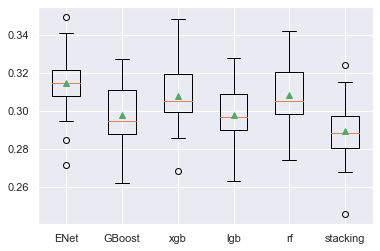

In [49]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [50]:
#looks like stacking does improve best model.
#create stacking predictions
model = get_stacking()

In [51]:
model.fit(X,y)

StackingRegressor(cv=5,
                  estimators=[('ENet',
                               Pipeline(steps=[('robustscaler', RobustScaler()),
                                               ('elasticnet',
                                                ElasticNet(alpha=0.2730923694779116,
                                                           l1_ratio=0.01))])),
                              ('GBoost', GradientBoostingRegressor()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_t...
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan

In [52]:
y_pred = model.predict(test2)

In [53]:
test_ID = pd.Series(test_ID)
y_pred = pd.Series(np.exp(y_pred))

In [56]:
final_blend = pd.DataFrame({'ID':test_ID, 'SalePrice': y_pred})

In [57]:
final_blend.to_csv('housingpreds2', index=False)

In [ ]:
#work with reduced data set
num = combine2
corr_df=train[num]  #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')
print(cor)

In [ ]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()